In [356]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import json
import time
import requests
from typing import Optional

In [357]:
def main(debug: Optional[bool] = False):
    
    pd.options.mode.chained_assignment = None 
    
    if debug:
        global api_data # debug mode
    
    #----------------API handling----------------
    api_decision = input("Do you want to do API requests? (requires ~20 minutes)? y/n: ")
    
    if api_decision == "y":
        
        url = "https://api.covid19api.com"
        
        check_connection(base=url)
        get_countries_list = request_countries(base=url)
        print_countries(c_list=get_countries_list)

        year_data_with_responses = gather_countries(c_list=get_countries_list, base=url)
        # returns: [countries_with_empty_response: list, countries_with_response: list, countries_df: DataFrame]

        empty_response_list = year_data_with_responses[0]
        non_empty_response_list = year_data_with_responses[1]
        world = year_data_with_responses[2]

        day_by_day_period_1 = make_period(from_data=[2020, 4, 1], to_date=[2021, 3, 30])
        day_by_day_period_2 = make_period(from_data=[2020, 4, 2], to_date=[2021, 3, 31])
        
        united_states = gather_day_by_day(periods_1=day_by_day_period_1, periods_2=day_by_day_period_2, base=url)
        update_to_non_empty_response(non_empty=non_empty_response_list, 
                                     empty=empty_response_list, 
                                     item="united-states")

        api_data = join_countries(df1=world, df2=united_states)
        
    elif api_decision == "n":
        try:
            api_data = load_csv_skip_api(path="data/world_and_usa_df.csv")
        except Exception as e:
            print("Error has occurred: ", e, "\n")
        
    else:
        print("Nothing to do here, go home")
        
    #----------------TOP 10 countries in the last month----------------
    input("Press ENTER to continue viewing TOP 10 countries in the last month: \n")
    
    for cat in ["Recovered", "Confirmed", "Deaths"]:
        masked_data = mask_date(data=api_data, category=cat, date_from="2021-3-1", date_to="2021-3-31")
        absolute_data = count_absolute_difference(data=masked_data, category=cat, row_limit=5889) 
        arranged_data = group_sum_sort(data=absolute_data, category=cat)
        print(arranged_data)
        plot_category(data=arranged_data, category=cat)
        
    #----------------Last month in Poland----------------
    input("Press ENTER to continue viewing Last month in Poland: \n")
    
    poland_df = choose_country(data=api_data, country="Poland")
    masked_poland = mask_date(data=poland_df, date_from="2021-3-1", date_to="2021-3-31")
    poland_no_outlier = outlier_for_active_category(data=masked_poland)
    print(poland_no_outlier)
    plot_categories(data=poland_no_outlier, x_ticks=True, y_ticks=True)
    
    #----------------Monthly growth----------------
    input("Press ENTER to continue viewing Monthly growth: \n")
    
    stripped_monthly_data = strip_date(data=api_data, category="Recovered")
    absolute_monthly_data = count_absolute_difference(data=stripped_monthly_data, category="Recovered", row_limit=2279)
    sorted_monthly_data = group_sum_sort2(data=absolute_monthly_data, category="Recovered")
    print(sorted_monthly_data)
    category_increment_plot(data=sorted_monthly_data, category="Recovered", x_ticks=True)

In [358]:
def check_connection(base: str) -> None:
    try:
        response = requests.get(base)
        print("Connection is fine!\n")
    except Exception as e:
        print("Error has occurred: ", e, "\n")

In [359]:
def request_countries(base: str, show_response: bool = False) -> list:
    """ """
    
    response = requests.get(base + "/countries")
    
    if show_response:
        print(response)
    
    countries_json = response.json()
    countries_list = []

    for item in countries_json:
        my_list = []
        my_list = item.get('Slug')
        countries_list.append(my_list)
    
    return countries_list

In [360]:
def print_countries(c_list: list) -> None:
    """ """
    
    data = c_list
    print("Number of all countries: ", len(data))
    print(*data, "\n", sep = ", ")

In [361]:
def gather_countries(c_list: list, base: str, save: bool = False) -> list:
    """time: ~ 9-15 min"""
    
    data = c_list
    countries_with_empty_response = []
    countries_with_response = []
    countries_data_list = []
    
    for country in data:
        response = requests.get(base + '/country/' + country + '?from=2020-04-01T00:00:00Z&to=2021-03-31T00:00:00Z')
        country_response = response.json()

        if len(country_response) <= 2:
            countries_with_empty_response.append(country)
            #continue
        else:
            countries_with_response.append(country)

            for item in country_response:
                my_dict = {}
                my_dict['Country'] = item.get('Country')
                my_dict['Confirmed'] = item.get('Confirmed')
                my_dict['Deaths'] = item.get('Deaths')
                my_dict['Recovered'] = item.get('Recovered')
                my_dict['Active'] = item.get('Active')
                my_dict['Date'] = item.get('Date')

                countries_data_list.append(my_dict)
        time.sleep(1)
    
    countries_data_json = json.dumps(countries_data_list)
    countries_df = pd.read_json(countries_data_json)
    
    if save:
        countries_df.to_csv('data/countries_df.csv', index=False)
    
    return [countries_with_empty_response, countries_with_response, countries_df]

In [362]:
def make_period(from_data: list, to_date: list) -> list:
    """ """
    
    start_date = datetime.date(from_data[0], from_data[1], from_data[2])
    end_date = datetime.date(to_date[0], to_date[1], to_date[2])
    delta = datetime.timedelta(days=1)
    
    dates_list = []

    while start_date <= end_date:
        dates_list.append(start_date)
        start_date += delta

    return dates_list

In [363]:
def gather_day_by_day(periods_1: list, periods_2: list, base: str, save: bool = False) -> list:
    """time: ~ 27-30 min"""
    
    usa_data_list = []
    
    for from_date, to_date in zip(periods_1, periods_2):
        response = requests.get(base + '/country/united-states' + f'?from={from_date}T00:00:00Z&to={to_date}T00:00:00Z')
        usa_data_json = response.json()
        
        for item in usa_data_json:
            my_dict = {}
            my_dict['Country'] = item.get('Country')
            my_dict['Confirmed'] = item.get('Confirmed')
            my_dict['Deaths'] = item.get('Deaths')
            my_dict['Recovered'] = item.get('Recovered')
            my_dict['Active'] = item.get('Active')
            my_dict['Date'] = item.get('Date')

            usa_data_list.append(my_dict)
        time.sleep(1)
    
    usa_data = json.dumps(usa_data_list)
    country_usa_df = pd.read_json(usa_data)

    if save:
        country_usa_df.to_csv('data/country_usa_df.csv', index=False)
    
    return country_usa_df

In [364]:
def update_to_non_empty_response(non_empty: list, empty: list, item: str = "united-states") -> list:
    """ """
    
    non_empty.append(item)
    print("Number of countries with data: ", len(non_empty))
    print(*non_empty, "\n", sep = ", ") 

    empty.remove(item)
    print("Number of countries without data: ", len(empty))
    print(*empty, "\n", sep = ", ")
    
    return [non_empty, empty]

In [365]:
def join_countries(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:   
    """ """
    
    countries_and_usa_df = df1.append(df2)
    countries_and_usa_df.to_csv('data/world_and_usa_df.csv', index=False)
    print("Finished dataframe:\n", countries_and_usa_df)
    
    return countries_and_usa_df

In [366]:
def load_csv_skip_api(path : str = "data/world_and_usa_df.csv") -> pd.DataFrame:
    """save 20 minutes of your life, skip api, load csv"""
    
    data = pd.read_csv("data/world_and_usa_df.csv")
    print("Data successfully loaded to 'api_data' variable!")
    
    return data

In [367]:
def mask_date(data: pd.DataFrame, date_from: str, date_to: str, category: Optional[str] = None) -> pd.DataFrame:
    """ """
    
    if category:
        masked_df = data[['Country', category, 'Date']]
    else:
        masked_df = data
        
    masked_df['Date'] = masked_df['Date'].astype(str).str[:10]
    masked_df['Date'] = pd.to_datetime(masked_df['Date'])
    
    date_mask = (masked_df['Date'] >= date_from) & (masked_df['Date'] <= date_to)
    masked_df = masked_df.loc[date_mask]
    
    masked_df.reset_index(drop=True, inplace=True)
    
    return masked_df

In [368]:
def count_absolute_difference(data: pd.DataFrame, category: str, row_limit: int) -> pd.DataFrame:
    """ """
    
    absolute_df = data[['Country', 'Date', category]].groupby(['Country', 'Date']).sum()
    absolute_df.reset_index(inplace=True)
    
    absolute_df['Test'] = absolute_df[category]
    absolute_df[f'{category}_increment'] = 0
    # absolute_df
    
    # 1 month limit means records for 1 country from last month
    # 5889 is last index, so there're 5890 rows -> 5890 / 190 = 31
    
    
    month_limit = 30
    df_limit = row_limit
    index_counter = 0

    while month_limit <= df_limit:          
    
        while index_counter <= month_limit and index_counter <= df_limit: 
            if index_counter == df_limit: 
                break
            else:
                # assigned value is our absolute difference = second row for category - first row for test
                # (test is a copy of category). To better understanding uncomment 'absolute_df'
                absolute_df[f'{category}_increment'][index_counter+1] = absolute_df[category][index_counter+1] - absolute_df['Test'][index_counter]
                index_counter += 1                 

        if index_counter >= month_limit:                               
            month_limit += 31

    return absolute_df

In [369]:
def group_sum_sort(data: pd.DataFrame, category: str) -> pd.DataFrame:
    """ """
    
    group_sum_sort_df = data[['Country', f'{category}_increment', 'Date']]
    
    group_sum_sort_df = group_sum_sort_df.groupby(by="Country").sum()
    group_sum_sort_df = group_sum_sort_df.sort_values(by=f'{category}_increment', ascending=False).head(10)
    
    return group_sum_sort_df

In [370]:
def plot_category(data: pd.DataFrame, category: str) -> plt:
    """ """
    
    plt.figure(figsize=(10 ,7))
    sns.barplot(x=data.index, y=f'{category}_increment', data=data)
    plt.title(f"TOP 10 countries with the highest number of {category} cases in the last month")
    plt.xticks(rotation=45)
    plt.grid()
    
    plt.tight_layout()
    
    return plt.show()

In [371]:
def choose_country(data: pd.DataFrame, country: str) -> pd.DataFrame:
    """ """
    
    country_df = data.loc[data["Country"]==country]
    country_df.reset_index(drop=True, inplace=True)
    
    return country_df

In [372]:
def outlier_for_active_category(data: pd.DataFrame) -> pd.DataFrame:
    """ """
    try:
        idx = data.index[data['Active'] > 1e6].tolist()
        data.iloc[idx[0], 4] = data.iloc[idx[0], 1] - data.iloc[idx[0], 2] - data.iloc[idx[0], 3]
    except Exception as e:
            print(f"Error has occurred: {e}. In this case there's no more outlieres in active category.")
            
    return data

In [373]:
def plot_categories(data: pd.DataFrame, x_ticks: bool = False, y_ticks: bool = False) -> plt:
    """ """
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)

    plt.suptitle("Statistics for Poland for the last month", fontsize=14)

    sns.lineplot(ax=axes[0], data=data, x='Date', y='Confirmed', color='orange', linewidth=2)
    axes[0].set_title("Confirmed")
    axes[0].grid(True)

    sns.lineplot(ax=axes[1], data=data, x='Date', y='Deaths', color='red', linewidth=2)
    axes[1].set_title("Deaths")
    axes[1].grid(True)

    sns.lineplot(ax=axes[2], data=data, x='Date', y='Recovered', color='green', linewidth=2)
    axes[2].set_title("Recovered")
    axes[2].grid(True)

    sns.lineplot(ax=axes[3], data=data, x='Date', y='Active', color='blue', linewidth=2)
    axes[3].set_title("Active")
    axes[3].grid(True)
        
    if x_ticks:
        axes[3].tick_params(axis='x', rotation=90)
        axes[3].set_xticks(data['Date'])
    
    if y_ticks:
        axes[0].set_yticks(range(int(16e5), int(25e5), int(1e5)))
        axes[1].set_yticks(range(42000, 56000, 2000))
        axes[2].set_yticks(range(int(14e5), int(20e5), int(1e5)))
        axes[3].set_yticks(range(200000, 480000, 40000))
        
    return plt.show()

In [374]:
def strip_date(data: pd.DataFrame, category: Optional[str] = None) -> pd.DataFrame:
    """ """
    
    if category:
        stripped_df = data[['Country', category, 'Date']]
    else:
        stripped_df = data
    
    stripped_df['Date'] = stripped_df['Date'].astype(str).str[:7]
    
    return stripped_df

In [375]:
def group_sum_sort2(data: pd.DataFrame, category: str) -> pd.DataFrame:
    """ """
    
    group_sort_df = data[['Country', category, f'{category}_increment', 'Date']]
    group_sort_df.loc[group_sort_df[f'{category}_increment'] < 0, f'{category}_increment'] = 0
    group_sort_df = group_sort_df.groupby(by="Date").sum()
    group_sort_df = group_sort_df.sort_values(by='Date', ascending=True)

    return group_sort_df

In [376]:
def category_increment_plot(data: pd.DataFrame, category: str,  x_ticks: bool = False) -> plt:
    """ """
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    plt.suptitle("Monthly growth in recoveries over the past year", fontsize=12)

    sns.lineplot(ax=axes[0], data=data, x='Date', y=f'{category}_increment', color='red', linewidth=2)
    axes[0].set_title("Increment")
    axes[0].grid(True)

    sns.lineplot(ax=axes[1], data=data, x='Date', y=category, color='green', linewidth=2)
    axes[1].set_title(category)
    axes[1].grid(True)
        
    if x_ticks:
        axes[1].tick_params(axis='x', rotation=45)
    
    return plt.show()

Do you want to do API requests? (requires ~20 minutes)? y/n:  n


Data successfully loaded to 'api_data' variable!


Press ENTER to continue viewing TOP 10 countries in the last month: 
 


                    Recovered_increment
Country                                
India                          11468625
Brazil                         11144413
Russian Federation              3268037
Turkey                          2796933
Germany                         2266493
Colombia                        2188979
Argentina                       2101796
Italy                           2093380
Mexico                          1772593
South Africa                    1469500


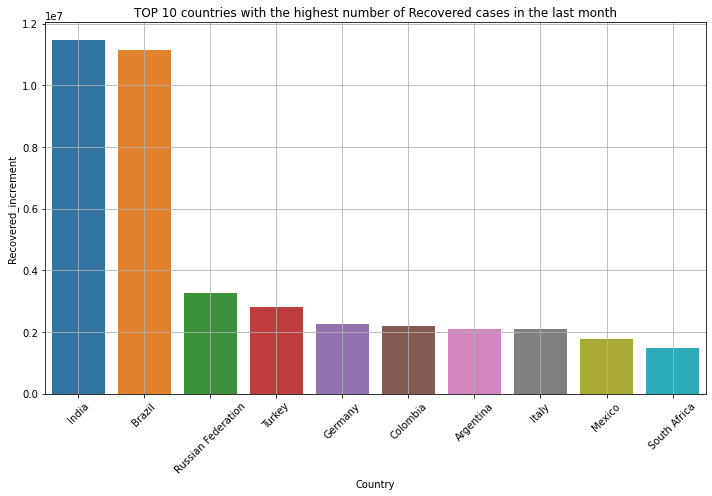

                          Confirmed_increment
Country                                      
United States of America             56529496
Brazil                               12708899
India                                12215460
France                                4627616
United Kingdom                        3898538
Russian Federation                    3541431
Spain                                 3274188
Turkey                                3063164
Italy                                 2751794
Germany                               2561883


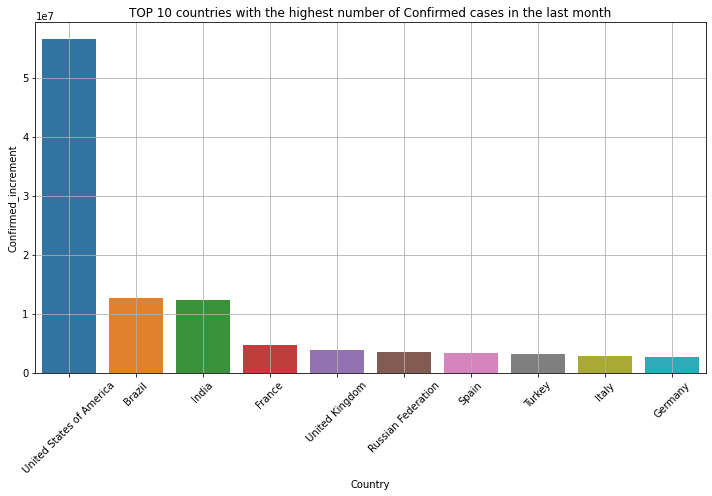

                          Deaths_increment
Country                                   
United States of America            978153
Brazil                              320947
Mexico                              203198
India                               162898
United Kingdom                      125458
Italy                               103137
France                               94954
Spain                                75350
Russian Federation                   73681
Germany                              72811


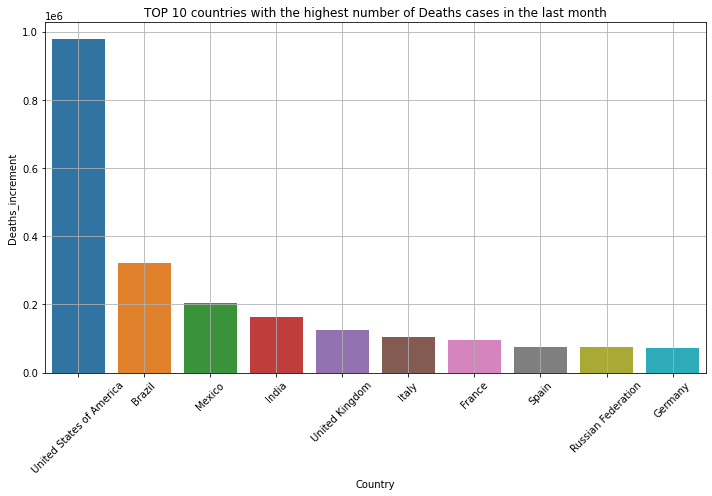

Press ENTER to continue viewing Last month in Poland: 
 


   Country  Confirmed  Deaths  Recovered  Active       Date
0   Poland    1711772   43793    1430861  237118 2021-03-01
1   Poland    1719708   44008    1438032  237668 2021-03-02
2   Poland    1735406   44360    1441479  249567 2021-03-03
3   Poland    1750659   44649    1448619  257391 2021-03-04
4   Poland    1766490   44912    1459564  262014 2021-03-05
5   Poland    1781345   45159    1471608  264578 2021-03-06
6   Poland    1794914   45285    1482568  267061 2021-03-07
7   Poland    1801083   45317    1494083  261683 2021-03-08
8   Poland    1811036   45599    1503353  262084 2021-03-09
9   Poland    1828313   45997    1507905  274411 2021-03-10
10  Poland    1849424   46373    1516540  286511 2021-03-11
11  Poland    1868297   46724    1530484  291089 2021-03-12
12  Poland    1889360   47068    1546151  296141 2021-03-13
13  Poland    1906632   47178    1560227  299227 2021-03-14
14  Poland    1917527   47206    1574455  295866 2021-03-15
15  Poland    1931921   47578    1587164

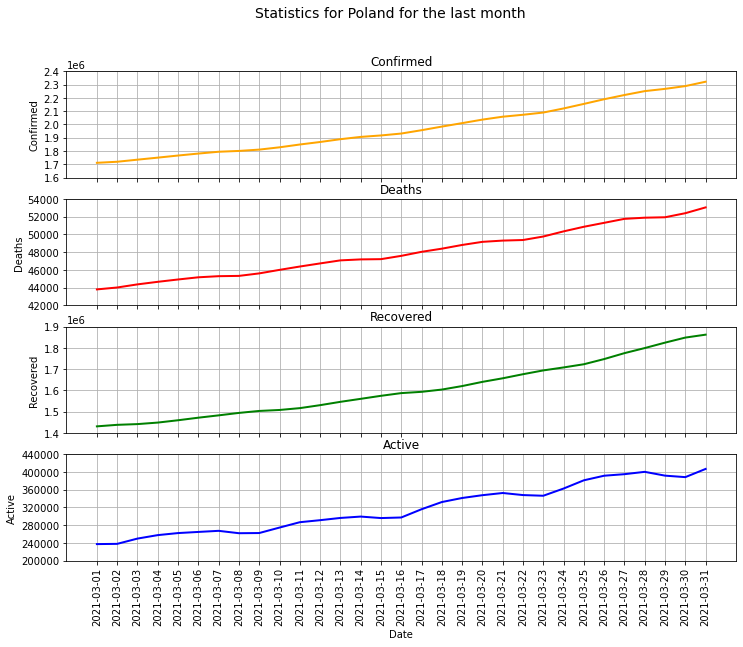

Press ENTER to continue viewing Monthly growth: 
 


          Recovered  Recovered_increment
Date                                    
2020-04    18035092              5580037
2020-05    62800819             44765299
2020-06   136295337             73565030
2020-07   276246691            140006982
2020-08   480383230            204317004
2020-09   684131518            203867652
2020-10   942757689            258573244
2020-11  1194087199            251972896
2020-12  1440386380            354078238
2021-01  1615010122            323423786
2021-02  1711114149            121280939
2021-03  2126472659            414373740


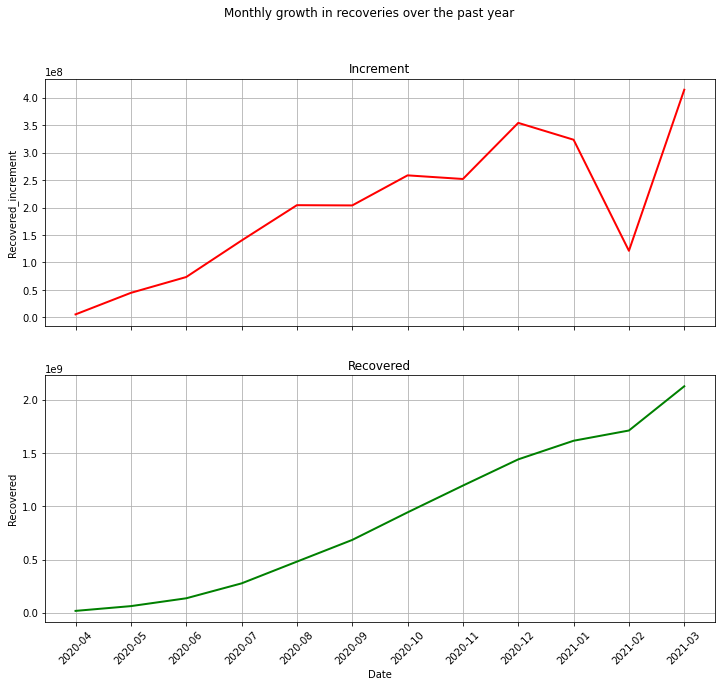

In [377]:
main()

In [378]:
# if __name__ == "__main__":
#     main()

In [379]:
# # shell command convert .ipynb to .py
# !jupyter nbconvert --to script 2021_Rozwiązanie_BAA_Intern_Dawid_Jaskulski.ipynb